Make virtual environment: python -m venv <kernelname>

To start virtual environment in terminal: .\<kernelname>\Scripts\activate
or conda create -n <kernelname> python=<pythonversion>


Tensorflow CPU: python 3.12.5

Tensorflow GPU: python 3.10.15


Adding virtual environment to jupyter notebook:
python -m ipykernel install --name=<kernelname>

In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


In [50]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.config.list_physical_devices('GPU'))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))


[]
tf.Tensor(-44.703125, shape=(), dtype=float32)


In [51]:
#get image count from folders
dirs = os.listdir("data")
total = 0
for dir in dirs:
    files = list(os.listdir("Data/"+dir))
    total+=len(files)
    print(dir + " directory has " + str(len(files)) + " images")
print("Total images: " + str(total))

apple_pie directory has 40 images
baby_back_ribs directory has 40 images
baklava directory has 40 images
beef_carpaccio directory has 40 images
beef_tartare directory has 40 images
beet_salad directory has 40 images
beignets directory has 40 images
bibimbap directory has 40 images
bread_pudding directory has 40 images
breakfast_burrito directory has 40 images
bruschetta directory has 40 images
caesar_salad directory has 40 images
cannoli directory has 40 images
caprese_salad directory has 40 images
carrot_cake directory has 40 images
ceviche directory has 40 images
cheesecake directory has 40 images
cheese_plate directory has 40 images
chicken_curry directory has 40 images
chicken_quesadilla directory has 40 images
chicken_wings directory has 40 images
chocolate_cake directory has 40 images
chocolate_mousse directory has 40 images
churros directory has 40 images
clam_chowder directory has 40 images
club_sandwich directory has 40 images
crab_cakes directory has 40 images
creme_brulee di

In [52]:
#Load images into array as dataset
base_dir = "data/"
img_size = 180
batch = 20

full_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=0,
    batch_size=batch,
    image_size=(img_size, img_size)
)

class_names = full_dataset.class_names
total_size = len(full_dataset)

train_size = int(total_size * 0.7)   # 70% for training
val_size = int(total_size * 0.2)     # 20% for validation
#test_size = total_size - train_size - val_size # 10% for test
test_size = int(total_size* 0.1)

# Split the dataset into train, validation, and test sets
train_ds = full_dataset.take(train_size)
validation_ds = full_dataset.skip(train_size).take(val_size)
test_ds = full_dataset.skip(train_size + val_size).take(test_size)

print(f'Train dataset size: {train_size}')
print(f'Validation dataset size: {val_size}')
print(f'Test dataset size: {test_size}')
print(class_names)


Found 4040 files belonging to 101 classes.
Train dataset size: 141
Validation dataset size: 40
Test dataset size: 20
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hum

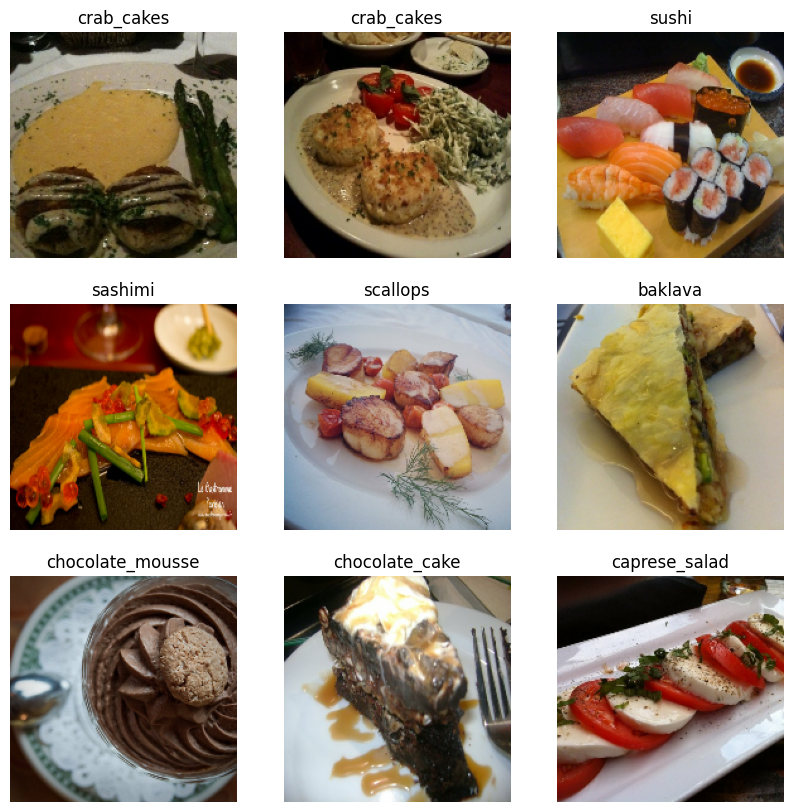

In [53]:
def displayImages(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Fetch one batch of images and labels
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots, i+1 is the column to put the image since plt starts at 1
            plt.imshow(images[i].numpy().astype('uint8'))  # Display the image
            plt.title(class_names[labels[i]])  # Set the title to the corresponding dish name
            plt.axis('off')  # Hide the axes
    plt.show() 
displayImages(train_ds, class_names)


In [54]:
#Caching data to improve loading and processing of data
AUTOTUNE = tf.data.AUTOTUNE  #allow TensorFlow to decide the optimal buffer size for prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE) #Caches the dataset in memory after the first epoch, so subsequent epochs can access it without reloading.
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

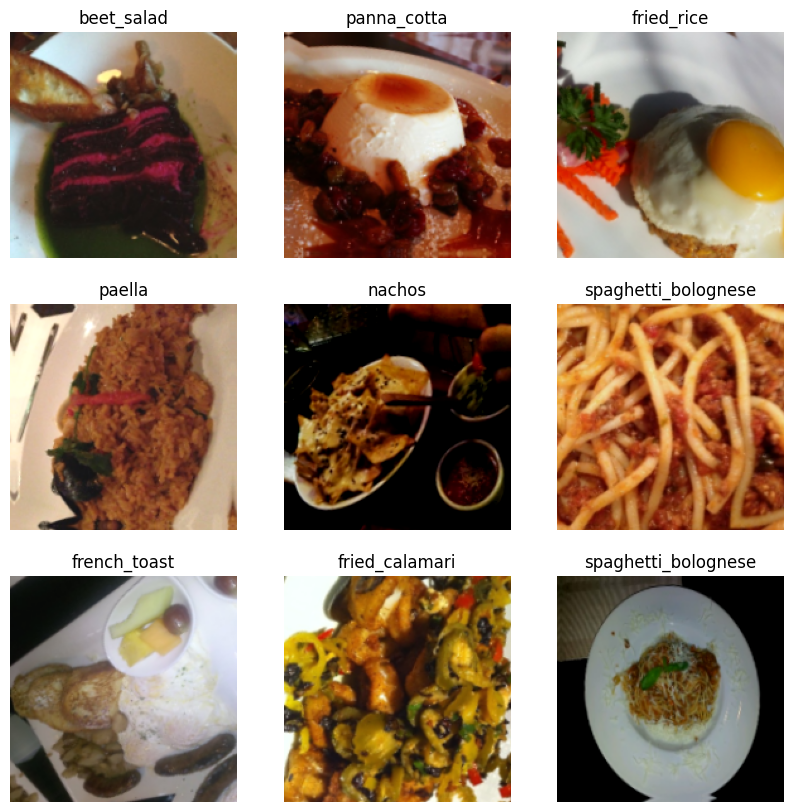

In [55]:
#Data Augmentation
#Increasing the size of dataset by randomly modifying existing images. Helps model learn better by providing diverse examples
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
])

def display_augmented_images(dataset, data_augmentation, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Fetch one batch of images and labels
        augmented_images = data_augmentation(images)  # Apply augmentation to the images
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
            plt.imshow(augmented_images[i].numpy().astype('uint8'))  # Display the augmented image
            plt.title(class_names[labels[i]])  # Set the title to the corresponding dish name
            plt.axis('off') 
    plt.show()

display_augmented_images(train_ds, data_augmentation, class_names)

In [72]:
#Model Creation

'''
Conv2D: 
    - Filters: 32 to detect 16 different patterns, 
    - Kernel size: 3 which slides across the image and looks at every 3x3 block of pixels to extract features
    - padding: "same" which adds padding around the image so that the output of this layer has the same height and width as the input
MaxPooling2D:
    Reduces the size of the image and focuses on important features


NOTES:
    - include dropout layer if model is overfitting
'''
model = Sequential([
    #data_augmentation, #First layer, used to randomly transform images during training to create more diverse samples
    layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)), #Every image has rgb colors ranging from 0-255, rescale to between 0 and 1
    Conv2D(16, (3, 3), padding="same", activation="relu"), #Not providing input in first layer because we're reading the data 
    MaxPooling2D(pool_size=(2, 2)), 
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)), 
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)), 
    Flatten(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dense(len(class_names), activation='softmax') 
])

c:\Users\incre\OneDrive\Documents\Dish-Classifier-ML\imageclassification\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 101)            │        13,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,001,669 (15.27 MB)

 Trainable params: 4,001,669 (15.27 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
logdir='logs'
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train_ds, epochs=20, validation_data=validation_ds, callbacks=[early_stopping])

Epoch 1/20


c:\Users\incre\OneDrive\Documents\Dish-Classifier-ML\imageclassification\Lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.0116 - loss: 4.6699 - val_accuracy: 0.0063 - val_loss: 4.6163
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 174ms/step - accuracy: 0.0157 - loss: 4.6111 - val_accuracy: 0.0113 - val_loss: 4.5862
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - accuracy: 0.0322 - loss: 4.4839 - val_accuracy: 0.0175 - val_loss: 4.5522
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.1261 - loss: 4.0110 - val_accuracy: 0.0725 - val_loss: 4.6623
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.3316 - loss: 2.9121 - val_accuracy: 0.0938 - val_loss: 5.5710
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.6166 - loss: 1.6274 - val_accuracy: 0.1150 - val_loss: 6.5634
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.8208 - loss: 0.7466 - val_accuracy: 0.1187 - val_loss: 8.3106
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.8832 - loss: 0.4673 - val

# Plot Performance

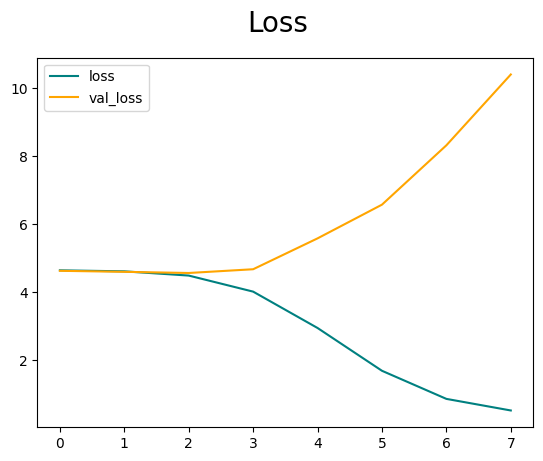

In [75]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

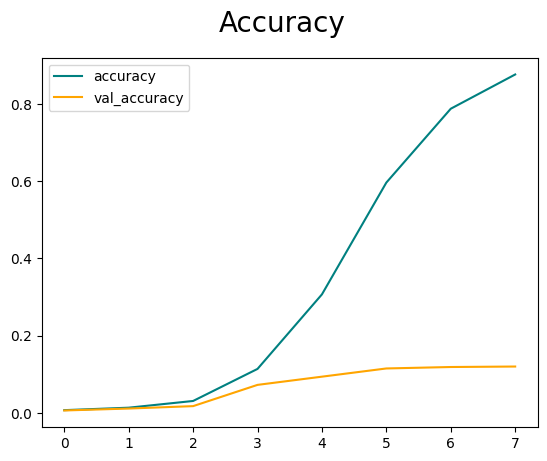

In [76]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Testing model


In [77]:
import cv2

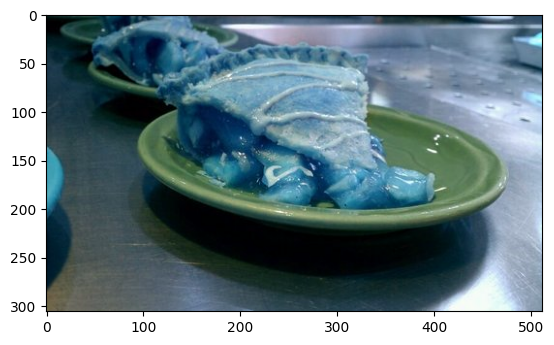

In [78]:
img = cv2.imread("AP_test.jpg")
plt.imshow(img)
plt.show()


In [79]:
def classifyImage(image_path, num=1):
    # Load and preprocess the image
    input_image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_expand_dim = tf.expand_dims(input_image_array, 0)  # Add batch dimension

    # Get predictions from the model
    predictions = model.predict(input_image_expand_dim)[0]

    # Get the indices of the top 'num' predictions
    top_indices = np.argsort(predictions)[-num:][::-1]  # Sort and get top 'num' indices in descending order

    # Retrieve the top 'num' class names and confidence scores
    top_predictions = [(class_names[i], predictions[i] * 100) for i in top_indices]

    # Print the top 'num' predictions with confidence
    for i, (class_name, confidence) in enumerate(top_predictions, 1):
        print(f"{i}. Predicted {class_name} with {confidence:.2f}% Confidence")

    return top_predictions
# def classifyImage(image_path, num=1):
#     #loading and preprocessing input image
#     input_image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
#     input_image_array = tf.keras.utils.img_to_array(input_image)
#     input_image_expand_dim = tf.expand_dims(input_image_array, 0)  # Add batch dimension

#     predictions = model.predict(input_image_expand_dim)  # Get predictions from the model

#     predicted_class_index = np.argmax(predictions[0]) 
#     predicted_class_name = class_names[predicted_class_index]
#     confidence = predictions[0][predicted_class_index] * 100
#     print(f"Predicted {predicted_class_name} with {confidence:.2f}% Confidence")
#     return predicted_class_name

classifyImage("AP_test2.jpg", 3)
#classifyImage("baklava_test.jpg", 3)
#classifyImage("BBR_test.jpg", 3)
#classifyImage("BC_test.jpg", 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1. Predicted pizza with 1.69% Confidence
2. Predicted bibimbap with 1.43% Confidence
3. Predicted macarons with 1.30% Confidence


[('pizza', 1.6947727650403976),
 ('bibimbap', 1.4285079203546047),
 ('macarons', 1.3042880222201347)]